# Generate Figure of Merit based dataset

This notebook is to generate a set of DR2-lite style `.par` and `.tim` files based on a figure of merit (FoM).
We include functions for a burst with memory (BWM) and stochastic gravitational wave background (gwb) FoM.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, glob
import json
import matplotlib.pyplot as plt
import libstempo as t2
from enterprise.signals import utils
import IPTA_DR2_analysis.utils as dr2u

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Update paths to reflect your usage.

In [4]:
project_path = '/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis'
DR2dir = os.path.abspath('/vast/palmer/home.grace/bbl29/DR2/')  # path to data for Docker image
datadir = os.path.join(DR2dir, 'release/VersionB')
lite_dir = os.path.join(project_path, 'data/lite_partim')  # cleaned/combined par/tim files

# 1) clean up `.par` and `.tim` files

## make list of pulsar names for later

In [5]:
psrlist = []
psrs = glob.glob(datadir + '/J*')
for psr in psrs:
    name = psr.split('/')[-1]
    psrlist.append(name)
psrlist.sort()
psrlist

['J0023+0923',
 'J0030+0451',
 'J0034-0534',
 'J0218+4232',
 'J0340+4130',
 'J0437-4715',
 'J0610-2100',
 'J0613-0200',
 'J0621+1002',
 'J0645+5158',
 'J0711-6830',
 'J0751+1807',
 'J0900-3144',
 'J0931-1902',
 'J1012+5307',
 'J1022+1001',
 'J1024-0719',
 'J1045-4509',
 'J1455-3330',
 'J1600-3053',
 'J1603-7202',
 'J1614-2230',
 'J1640+2224',
 'J1643-1224',
 'J1713+0747',
 'J1721-2457',
 'J1730-2304',
 'J1732-5049',
 'J1738+0333',
 'J1741+1351',
 'J1744-1134',
 'J1747-4036',
 'J1751-2857',
 'J1801-1417',
 'J1802-2124',
 'J1804-2717',
 'J1824-2452A',
 'J1832-0836',
 'J1843-1113',
 'J1853+1303',
 'J1857+0943',
 'J1903+0327',
 'J1909-3744',
 'J1910+1256',
 'J1911+1347',
 'J1911-1114',
 'J1918-0642',
 'J1923+2515',
 'J1939+2134',
 'J1944+0907',
 'J1949+3106',
 'J1955+2908',
 'J2010-1323',
 'J2017+0603',
 'J2019+2425',
 'J2033+1734',
 'J2043+1711',
 'J2124-3358',
 'J2129-5721',
 'J2145-0750',
 'J2214+3000',
 'J2229+2643',
 'J2302+4442',
 'J2317+1439',
 'J2322+2057']

## clean `.par` files

In [6]:
# note these are cleaned, fully combined parfiles
# all it does is add DM1, DM2 to par if not present already
parfiles = glob.glob(datadir + '/J*/*IPTADR2.par')

for p in parfiles:
    name = p.split('/')[-2]
    outfile = os.path.join(lite_dir, '{}.par'.format(name))
    dr2u.clean_par(p, outfile)

## combine `.tim` files

In [7]:
timfiles = glob.glob(datadir + '/J*/*IPTADR2.tim')

for t in timfiles:
    name = t.split('/')[-2]
    outfile = os.path.join(lite_dir, '{}.tim'.format(name))
    dr2u.combine_tim(t, outfile)

# 2) Figure of Merit Calculation

Calculate the FoM for each pulsar for each PTA that observes it.
Both of these FoMs are for white noise dominated pulsars, which is not true... You may want to modify them.

## Burst with Memory FoM
From van Haasteren & Levin (2010) the uncertainty on the measurement of the BWM amplitude is estimated for even cadence, white-noise dominated observations.  Madison *et al*. (2014) interpret this as the minimum amplitude for a 1-$\sigma$ detection.

$$ \sigma_{h_0} = h_{min} \sim \sigma_\star \,\Delta t^{1/2}\, T^{-3/2}, $$

where $\sigma_\star$ is the TOA measurment uncertainty for a single pulsar or the response weighted root-mean-squared of uncertainty for all pulsars in a network, $\Delta t$ is the observing cadence, and $T$ the observation baseline.

To maximize the sensitivity of our array we want to minimize $\sigma_{h_0}$.
We define our figure of merit for pulsar selection as:
$$ \mathrm{FoM}_{bwm} = \frac{1}{\sigma_{h_0}} = \sqrt{\frac{T^{3}}{\left<{\sigma_{TOA}}\right>^2 \, \Delta t}} $$

## Gravitational Wave Background FoM

From GWB signal-to-noise ratio (SNR) scaling laws in Siemens, et al. 2013. 

The weak signal scaling law, used at the December 2017 busyweek at Flatiron CCA in NYC gives a FoM of:

$$ \mathrm{FoM}_{gwb} = \frac{T^\frac{13}{3}}{\left<{\sigma_{TOA}}\right>^2 \, \Delta t} $$

And the intermediate regime sclaing gives the following Figure of Merit:

$$ \mathrm{FoM}_{gwb} = T^\frac{1}{2}\left(\frac{1}{\left<{\sigma_{TOA}}\right>^2 \, \Delta t}\right)^\frac{1}{2\beta} $$

In [8]:
def bwm_FoM(Tobs, dt, TOAerr):
    """BWM FoM = 1/sig_h0
    """
    return np.sqrt(Tobs**3/dt) / TOAerr

def gwb_FoM_weak(Tobs, dt, TOAerr):
    """GWB FoM from SNR scaling laws
    """
    return Tobs**(13/3) / TOAerr**2 / dt 

def gwb_FoM_inter(Tobs, dt, TOAerr):
    """GWB FoM from SNR scaling laws
    """
    return Tobs**(1/2) * (TOAerr**2 * dt) ** (-1/(2*13/3)) 

In [9]:
# analysis tag to use in filenames
tag = "inter_gwb_3yrcut_unfiltered"
my_FoM = gwb_FoM_inter  # function alias for FoM of choice

# filter parameters
BW = 0.5 # 1.1
DM_window = 50 # days # 10

# best PSR selection parameters
Tmin = 3.0  # yrs
sigmax = 10.0  # us

In [10]:
ptas = ['PPTA', 'EPTA', 'NANOGrav']
backends = {'NANOGrav': 
                ['327_ASP', '430_ASP', 'L-wide_ASP', 'S-wide_ASP',
                 '327_PUPPI', '430_PUPPI', 'L-wide_PUPPI',  'S-wide_PUPPI',
                 'Rcvr_800_GASP', 'Rcvr1_2_GASP',
                 'Rcvr_800_GUPPI', 'Rcvr1_2_GUPPI',
                ],
            'PPTA': 
                ['PDFB_10CM', 'PDFB_20CM', 'PDFB_40CM',
                 'CPSR2_20CM', 'CPSR2_50CM',
                 'WBCORR_10CM', 'WBCORR_20CM',
                ],
                
            'EPTA': 
                ['EFF.EBPP.1360', 'EFF.EBPP.1410', 'EFF.EBPP.2639',
                 'JBO.DFB.1400', 'JBO.DFB.1520',
                 'NRT.BON.1400', 'NRT.BON.1600', 'NRT.BON.2000',
                 'WSRT.P1.328', 'WSRT.P1.328.C', 'WSRT.P1.323.C',
                 'WSRT.P1.382', 'WSRT.P1.382.C', 'WSRT.P1.367.C',
                 'WSRT.P1.840', 'WSRT.P1.840.C',
                 'WSRT.P1.1380', 'WSRT.P1.1380.C',
                 'WSRT.P1.1380.1',
                 'WSRT.P1.1380.2', 'WSRT.P1.1380.2.C',
                 'WSRT.P1.2273.C',
                ]
           }  # backends to use for each PTA, values for `-group` flag

### Backend Notes:
#### NANOGrav

legacy, not used (`-group` flag)
```
kaspi
kaspi23 (-be mk3_23m, mk2_23)
kaspi14 (-be mk3_14m, mk2_14, mk3_14r)
L-band_Mark3a
L-band_Mark3b
L-band_Mark4
S-band_Mark4
L-band_ABPP
S-band_ABPP
```

#### PPTA

backend list for `-f` flag
```
['1050CM_PDFB1', '1050CM_PDFB2', '1050CM_PDFB3', '1050CM_PDFB4',
 '1050CM_WBCORR',
 'H-OH_CPSR2m', 'H-OH_CPSR2n', 'H-OH_PDFB1',
 'MULTI_CPSR2m', 'MULTI_CPSR2n',
 'MULTI_PDFB1', 'MULTI_PDFB2', 'MULTI_PDFB3', 'MULTI_PDFB4',
 'MULTI_WBCORR',
]
```
small number of TOAs
```
CPSR2_40CM -- J0437 & J0711 & J1045 & J2129 TOA total <3 TOAs / psr
PDFB1_early_10CM -- J1824-2452A -- 7 TOAs total
PDFB1_early_20CM -- J1824-2452A -- 1 TOA
PDFB_50CM -- J0437 & J1045, 2 TOAs total
PDFB1_20CM -- J1824-2452A, 4 TOAs total
PDFB1_10CM -- J1824-2452A, 13 TOAs total
WBCORR_20CM -- 11 Parkes PSRs, 30 TOAs for J0437, rest with <10 (still used... should it be?)
```
there are some backends with `legacy` in the name... I'm not using those.  They have lots of missing metadata.
```
PKS.fptm.20cm-legacy
PKS.s2.20cm-legacy
PKS.cpsr1.20cm_legacy
PKS.cpsr2.20cm_legacy
PKS.AFB.20cm_legacy
PKS.cpsr2.50cm_legacy
```

#### EPTA

possible legacy, only used for single freq J1939
```
NRT.DDS.1400
```
small number of TOAs
```
JBO.DFB.5000 -- J1713, 4 TOAs

```

### Construct `FoM_dict` (takes a long time, skip if already saved)

Runs `filter_psr()` for each pulsar for each PTA, computing the FoM.

I've modified the below to filter by pta but not apply any backend filters

In [11]:
redo = True

dict_file = f'{project_path}/FoM_output/FoM_{tag}_dict.json'  # where to save FoM dictionary
data_file = f'{project_path}/FoM_output/FoM_{tag}.dat'  # plain text file of FoM data

In [13]:
if redo or not os.path.isfile(dict_file):
    FoM_dict = {}
    fout = open(data_file, 'w')
    fout.write('{:11}{:9}{:9}{:9}{:9}{:9}{:12}\n'
               .format(' Pulsar', ' PTA', ' raw_Tobs', '  mf_Tobs', '  TOAerr', '  cadence', '      FoM'))

    for psrName in psrlist:
        FoM_dict[psrName] = {}
    
        parfile = os.path.join(lite_dir, '{}.par'.format(psrName))
        timfile = os.path.join(lite_dir, '{}.tim'.format(psrName))
        psr = t2.tempopulsar(parfile, timfile, maxobs=30000)
        #plt.figure(figsize=(10,4),dpi=300)
        for i, pta in enumerate(ptas):
            if pta in psr.flagvals('pta'):
                FoM_dict[psrName][pta] = {}
                filt = {'pta':[pta]}#, 'group':backends[pta]}
                psr = dr2u.filter_psr(psr, filter_dict=filt, frequency_filter=False,
                                      plot=False, min_toas=0)
                nix = psr.flagvals('pta') == pta
                #plt.scatter(psr.toas()[nix], psr.freqs[nix], color=f'C{i}', label=pta, alpha=0.1, s=20)
                #plt.scatter(psr.toas()[~psr.deletedmask()], psr.freqs[~psr.deletedmask()], color=f'C{i}',
                #            alpha=1, label=f'{pta} filtered', edgecolor='k', lw=0.3, s=20)
                
                idx = ~psr.deletedmask()
                Tobs_raw = (psr.toas().max()-psr.toas().min()) / 365.25
                if len(psr.toas()[idx]) > 0:
                    U, _ = utils.create_quantization_matrix(psr.toas()[idx]*86400, dt=86400, nmin=1)
                    cadence = (psr.toas()[idx].max() - psr.toas()[idx].min()) / U.shape[1] # mean dt
                    Tobs = (psr.toas()[idx].max()-psr.toas()[idx].min()) / 365.25
                    sigma = 1 / np.mean(1/psr.toaerrs[idx])  # harmonic mean TOAerr
                    FoM = my_FoM(Tobs, cadence, sigma)
                else:
                    Tobs = 0
                    sigma = np.inf
                    cadence = np.inf
                    FoM = 0
                fout.write('{:11}{:9}{:9.2f}{:9.2f}{:9.2f}{:9.2f}{:9.2f}\n'
                            .format(psrName, pta, Tobs_raw, Tobs, sigma, cadence, FoM))
                FoM_dict[psrName][pta]['Tobs'] = Tobs
                FoM_dict[psrName][pta]['dt'] = cadence
                FoM_dict[psrName][pta]['sigma'] = sigma
                FoM_dict[psrName][pta]['FoM'] = FoM
        del psr
        #plt.legend(loc='best', frameon=False)
        #plt.title(psrName)
        #plt.show()
    fout.close()

Working on PSR J0023+0923
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J0023+0923 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J0030+0451
Keeping TOAs corresponding to pta ['EPTA']
Cutting 2455 TOAs
Turning off fit for ['JUMP9']
All TOAs are being jumped!
Setting JUMP5 as reference jump.
Working on PSR J0030+0451
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 907 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP6', 'JUMP7']
[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J0034-0534
Keeping TOAs corresponding to pta ['EPTA']
Cutting 0 TOAs
[preProcess.C:

Working on PSR J1455-3330
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 524 TOAs
Turning off fit for ['JUMP2', 'JUMP3']
[preProcess.C:158] Warning: PSR J1455-3330 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J1600-3053
Keeping TOAs corresponding to pta ['PPTA']
Cutting 8335 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP6']
All TOAs are being jumped!
Setting JUMP13 as reference jump.
Working on PSR J1600-3053
Keeping TOAs corresponding to pta ['EPTA']
Cutting 8475 TOAs
Turning off fit for ['JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28']
Working on PSR J1600-3053
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 1202 TOAs
[preProcess.C:1

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1801-1417 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J1802-2124
Keeping TOAs corresponding to pta ['EPTA']
Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1802-2124 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J1804-2717
Keeping TOAs corresponding to pta ['EPTA']
Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1804-2717 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J1824-2452A
Keeping TOAs corresponding to pta ['PPTA']
Cutting 0 TOAs
[preProcess.C:158] Warni

Cutting 1302 TOAs
Turning off fit for ['JUMP5']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
Working on PSR J1955+2908
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 157 TOAs
Turning off fit for ['JUMP2', 'JUMP3', 'JUMP4']
[preProcess.C:158] Warning: PSR J1955+2908 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

Working on PSR J2010-1323
Keeping TOAs corresponding to pta ['EPTA']
Cutting 7667 TOAs
Turning off fit for ['JUMP6']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
Working on PSR J2010-1323
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 390 TOAs
Turning off fit for ['JUMP2', 'JUMP3', 'JUMP4', 'JUMP5']
[preProcess.C:158] Warning: PSR J2010-1323 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues

Working on PSR J1713+0747
Keeping TOAs corresponding to pta ['PPTA']
Keeping TOAs corresponding to group ['PDFB_10CM', 'PDFB_20CM', 'PDFB_40CM', 'CPSR2_20CM', 'CPSR2_50CM', 'WBCORR_10CM', 'WBCORR_20CM']
Running multi-frequency filter
backends marked as 'orphan': [['WBCORR_20CM', 2]]
Cutting 17060 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP33', 'JUMP42', 'JUMP43', 'JUMP44', 'JUMP45', 'JUMP46', 'JUMP47', 'JUMP48']
All TOAs are being jumped!
Setting JUMP41 as reference jump.
Working on PSR J1713+0747
Keeping TOAs corresponding to pta ['EPTA']
Keeping TOAs corresponding to group ['EFF.EBPP.1360', 'EFF.EBPP.1410', 'EFF.EBPP.2639', 'JBO.DFB.1400', 'JBO.DFB.1520', 'NRT.BON.1400', 'NRT.BON.1600', 'NRT.BON.2000', 'WSRT.P1.328', 'WSRT.P1.328.C', 'WSRT.P1.323.C', 'WSRT.P1.382', 'WS

Text(0.5, 1.0, 'J1713+0747')

[preProcess.C:158] Warning: PSR J1713+0747 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1713+0747 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



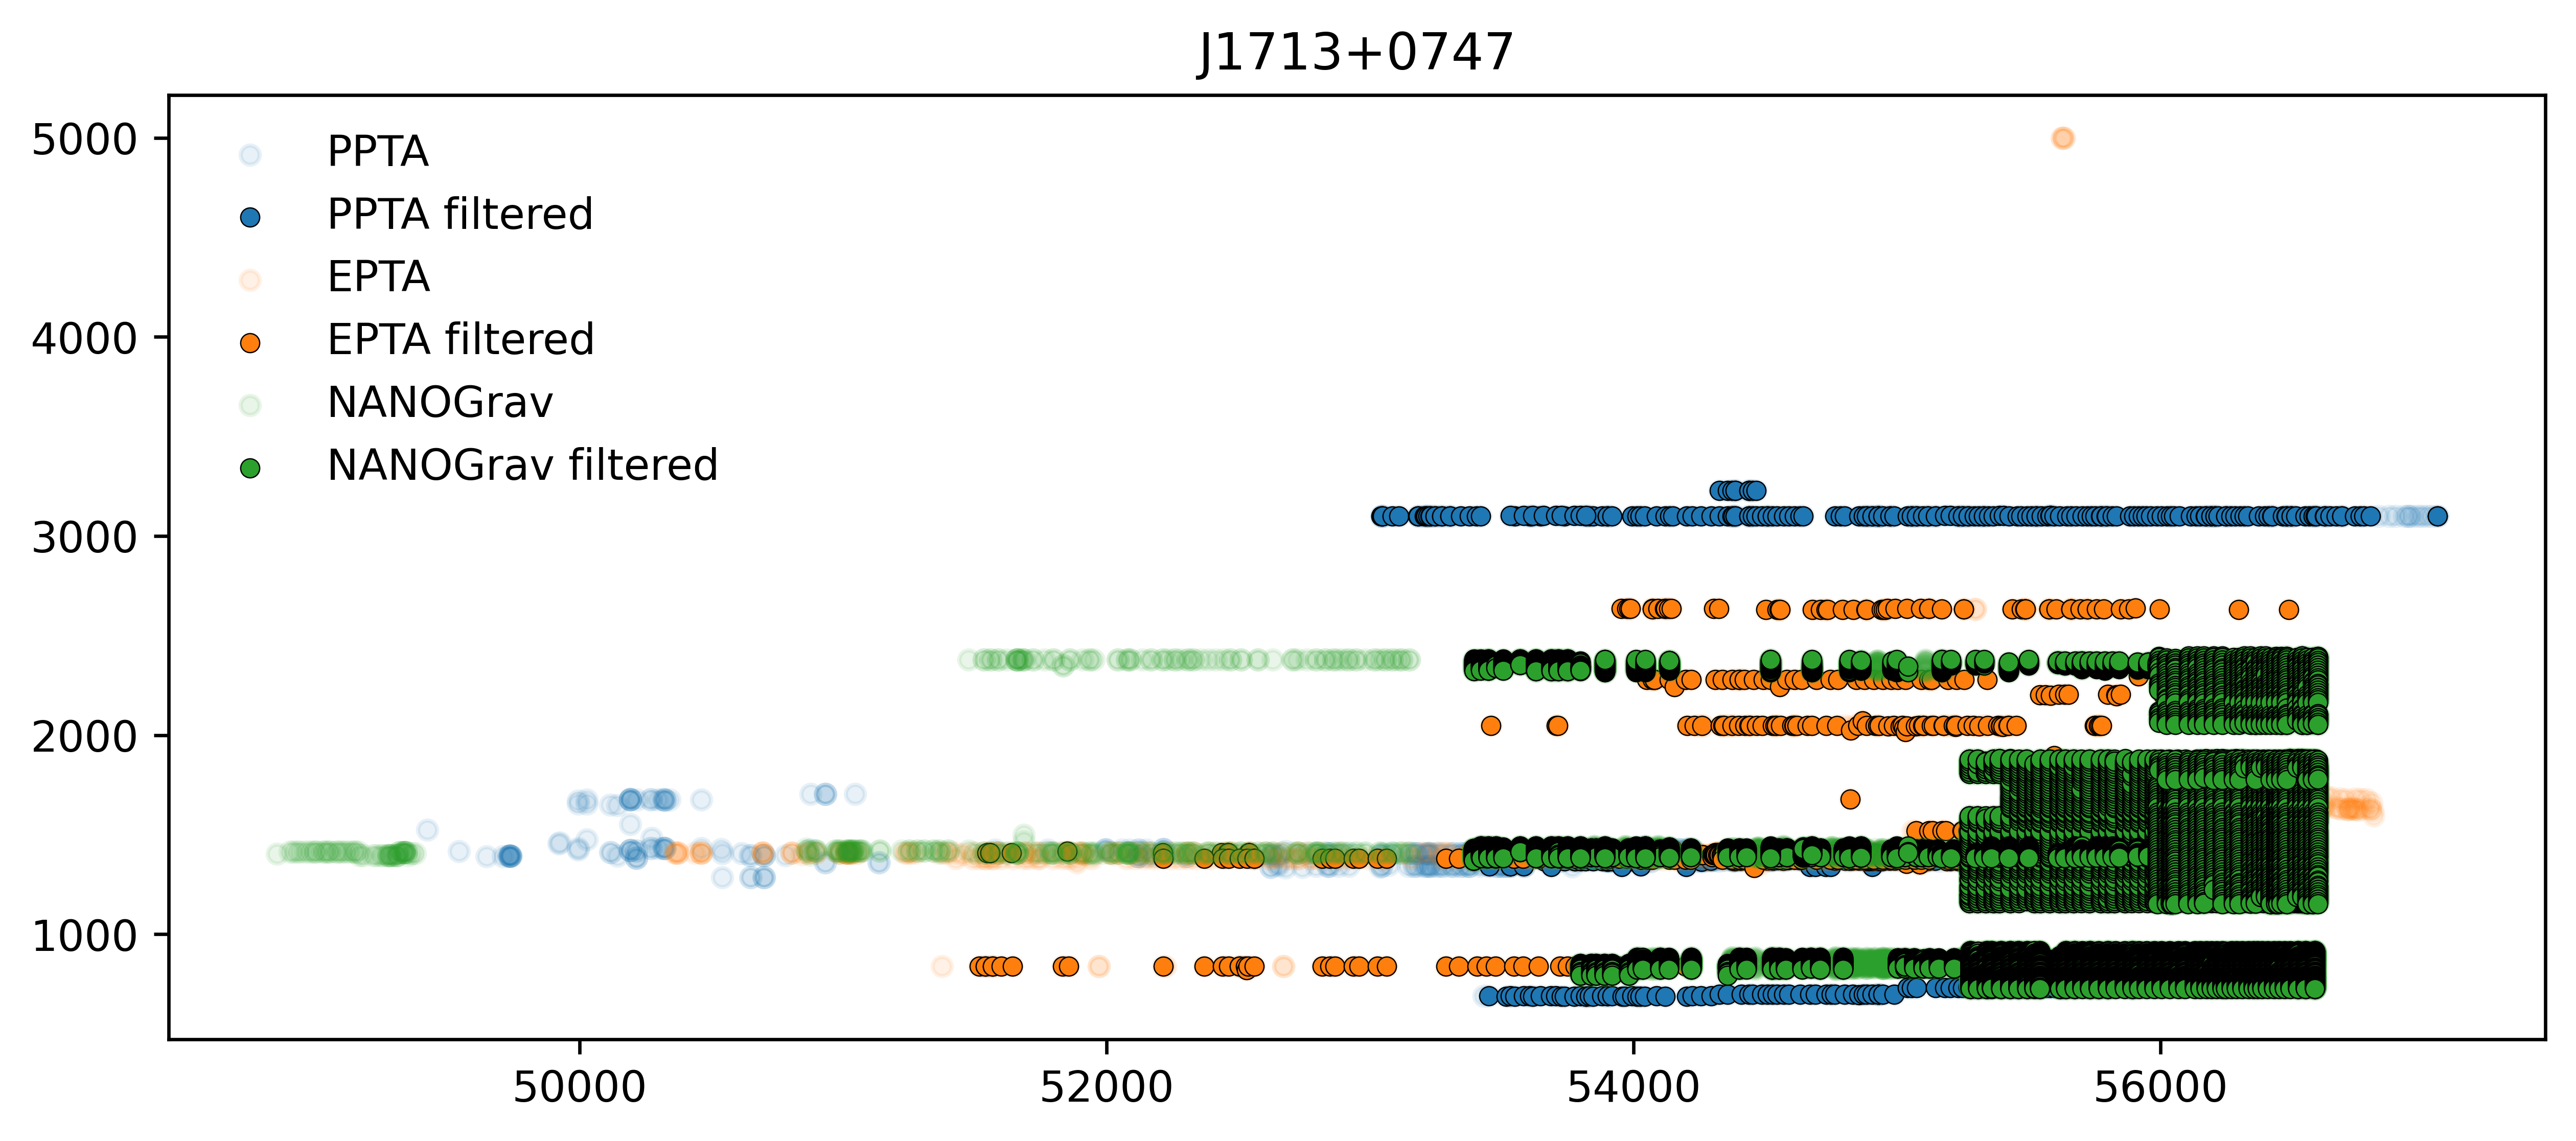

In [23]:
#psrName = 'J1713+0747'
#parfile = os.path.join(lite_dir, '{}.par'.format(psrName))
#timfile = os.path.join(lite_dir, '{}.tim'.format(psrName))
#psr = t2.tempopulsar(parfile, timfile, maxobs=30000)
#plt.figure(figsize=(10,4),dpi=300)
#for i, pta in enumerate(ptas):
#    if pta in psr.flagvals('pta'):
#        filt = {'pta':[pta], 'group':backends[pta]}
#        psr = dr2u.filter_psr(psr, bw=BW, dt=DM_window, filter_dict=filt, plot=False)
#        nix = psr.flagvals('pta') == pta
#        plt.scatter(psr.toas()[nix], psr.freqs[nix], color=f'C{i}', label=pta, alpha=0.1, s=20)
#        plt.scatter(psr.toas()[~psr.deletedmask()], psr.freqs[~psr.deletedmask()], color=f'C{i}',
#                    alpha=1, label=f'{pta} filtered', edgecolor='k', lw=0.3, s=20)
#del psr
#plt.legend(loc='best', frameon=False)
#plt.title(psrName)

### save `FoM_dict` as `json` database for later usage

In [14]:
dict_file

'/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis/FoM_output/FoM_inter_gwb_3yrcut_unfiltered_dict.json'

In [15]:
if redo or not os.path.isfile(dict_file):

    # convert FoM_dict to python float (json can't handle numpy.float128)
    for psr in FoM_dict.keys():
        for pta in FoM_dict[psr].keys():
            for key in FoM_dict[psr][pta].keys():
                FoM_dict[psr][pta][key] = float(FoM_dict[psr][pta][key])

    with open(dict_file, 'w') as fout:
        json.dump(FoM_dict, fout, sort_keys=True, indent=4, separators=(',', ': '))

In [49]:
dict_file

'/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis/FoM_output/FoM_inter_gwb_3yrcut_unfiltered_dict.json'

### compute FoM on the combined dataset while we are at it

In [16]:
import tqdm

In [25]:
FoM_dict_combined = {}
fout = open(data_file, 'w')
fout.write('{:11}{:9}{:9}{:9}{:9}{:9}{:12}\n'
           .format(' Pulsar', ' PTA', ' raw_Tobs', '  mf_Tobs', '  TOAerr', '  cadence', '      FoM'))

for psrName in tqdm.tqdm(psrlist):
    FoM_dict[psrName] = {}

    parfile = os.path.join(lite_dir, '{}.par'.format(psrName))
    timfile = os.path.join(lite_dir, '{}.tim'.format(psrName))
    psr = t2.tempopulsar(parfile, timfile, maxobs=30000)
    FoM_dict_combined[psrName] = {}
    Tobs = (psr.toas().max()-psr.toas().min()) / 365.25
    U, _ = utils.create_quantization_matrix(psr.toas()*86400, dt=86400, nmin=1)
    cadence = (psr.toas().max() - psr.toas().min()) / U.shape[1] # mean dt
    Tobs = (psr.toas().max()-psr.toas().min()) / 365.25
    sigma = 1 / np.mean(1/psr.toaerrs)  # harmonic mean TOAerr
    FoM = my_FoM(Tobs, cadence, sigma)
    fout.write('{:11}{:9}{:9.2f}{:9.2f}{:9.2f}{:9.2f}{:9.2f}\n'
                .format(psrName, pta, Tobs_raw, Tobs, sigma, cadence, FoM))
    FoM_dict_combined[psrName]['Tobs'] = Tobs
    FoM_dict_combined[psrName]['dt'] = cadence
    FoM_dict_combined[psrName]['sigma'] = sigma
    FoM_dict_combined[psrName]['FoM'] = FoM

  2%|▏         | 1/65 [00:00<00:29,  2.17it/s]

[preProcess.C:158] Warning: PSR J0023+0923 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



  3%|▎         | 2/65 [00:00<00:25,  2.46it/s]

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



  6%|▌         | 4/65 [00:01<00:12,  4.79it/s]

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



  8%|▊         | 5/65 [00:01<00:14,  4.03it/s]

[preProcess.C:158] Warning: PSR J0340+4130 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 11%|█         | 7/65 [00:02<00:19,  3.03it/s]

[preProcess.C:158] Warning: PSR J0610-2100 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 14%|█▍        | 9/65 [00:03<00:24,  2.26it/s]

[preProcess.C:158] Warning: PSR J0621+1002 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 15%|█▌        | 10/65 [00:03<00:23,  2.37it/s]

[preProcess.C:158] Warning: PSR J0645+5158 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0711-6830 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 20%|██        | 13/65 [00:04<00:12,  4.27it/s]

[preProcess.C:158] Warning: PSR J0751+1807 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0900-3144 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0931-1902 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1012+5307 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 25%|██▍       | 16/65 [00:06<00:19,  2.48it/s]

[preProcess.C:158] Warning: PSR J1022+1001 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1024-0719 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 26%|██▌       | 17/65 [00:06<00:23,  2.04it/s]

[preProcess.C:158] Warning: PSR J1045-4509 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1455-3330 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 29%|██▉       | 19/65 [00:07<00:19,  2.34it/s]

[preProcess.C:158] Warning: PSR J1600-3053 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 31%|███       | 20/65 [00:08<00:26,  1.72it/s]

[preProcess.C:158] Warning: PSR J1603-7202 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1614-2230 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 35%|███▌      | 23/65 [00:09<00:20,  2.09it/s]

[preProcess.C:158] Warning: PSR J1640+2224 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1643-1224 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 37%|███▋      | 24/65 [00:10<00:24,  1.66it/s]

[preProcess.C:158] Warning: PSR J1713+0747 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 42%|████▏     | 27/65 [00:12<00:23,  1.65it/s]

[preProcess.C:158] Warning: PSR J1721-2457 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1730-2304 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 45%|████▍     | 29/65 [00:13<00:15,  2.25it/s]

[preProcess.C:158] Warning: PSR J1732-5049 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1738+0333 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 46%|████▌     | 30/65 [00:13<00:13,  2.57it/s]

[preProcess.C:158] Warning: PSR J1741+1351 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1744-1134 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 49%|████▉     | 32/65 [00:15<00:17,  1.89it/s]

[preProcess.C:158] Warning: PSR J1747-4036 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1751-2857 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1801-1417 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 58%|█████▊    | 38/65 [00:15<00:05,  5.33it/s]

[preProcess.C:158] Warning: PSR J1802-2124 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1804-2717 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1824-2452A uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1832-0836 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 62%|██████▏   | 40/65 [00:15<00:04,  6.10it/s]

[preProcess.C:158] Warning: PSR J1843-1113 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1853+1303 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1857+0943 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 65%|██████▍   | 42/65 [00:16<00:05,  4.28it/s]

[preProcess.C:158] Warning: PSR J1903+0327 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1909-3744 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 68%|██████▊   | 44/65 [00:18<00:08,  2.46it/s]

[preProcess.C:158] Warning: PSR J1910+1256 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1911+1347 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1911-1114 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1918-0642 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 74%|███████▍  | 48/65 [00:19<00:05,  2.91it/s]

[preProcess.C:158] Warning: PSR J1923+2515 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J1939+2134 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 77%|███████▋  | 50/65 [00:21<00:07,  1.95it/s]

[preProcess.C:158] Warning: PSR J1944+0907 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 78%|███████▊  | 51/65 [00:21<00:05,  2.35it/s]

[preProcess.C:158] Warning: PSR J1949+3106 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 80%|████████  | 52/65 [00:21<00:05,  2.57it/s]

[preProcess.C:158] Warning: PSR J1955+2908 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2010-1323 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 83%|████████▎ | 54/65 [00:22<00:04,  2.37it/s]

[preProcess.C:158] Warning: PSR J2017+0603 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2019+2425 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2033+1734 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 88%|████████▊ | 57/65 [00:22<00:01,  4.30it/s]

[preProcess.C:158] Warning: PSR J2043+1711 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2124-3358 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 89%|████████▉ | 58/65 [00:23<00:01,  4.58it/s]

[preProcess.C:158] Warning: PSR J2129-5721 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2145-0750 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 94%|█████████▍| 61/65 [00:24<00:01,  3.06it/s]

[preProcess.C:158] Warning: PSR J2214+3000 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



 97%|█████████▋| 63/65 [00:24<00:00,  3.63it/s]

[preProcess.C:158] Warning: PSR J2229+2643 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2302+4442 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



100%|██████████| 65/65 [00:25<00:00,  2.58it/s]

[preProcess.C:158] Warning: PSR J2317+1439 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J2322+2057 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



In [29]:
dict_file_combined = f'{project_path}/FoM_output/FoM_combined_dict.json' # where to save FoM dictionary

if redo or not os.path.isfile(dict_file_combined):

    # convert FoM_dict to python float (json can't handle numpy.float128)
    for psr in FoM_dict_combined.keys():
        for key in FoM_dict_combined[psr].keys():
            FoM_dict_combined[psr][key] = float(FoM_dict_combined[psr][key])

    with open(dict_file_combined, 'w') as fout:
        json.dump(FoM_dict_combined, fout, sort_keys=True, indent=4, separators=(',', ': '))

# 3) Select pulsars to use

Use only PSRs with `Tmin` yrs of multi-frequency data.  Pick one PTA per pulsar.

In [23]:
#dict_file = 'FoM_output/FoM_{}_dict.json'.format(tag)  # FoM dictionary, same as above
with open(dict_file, 'r') as fin:
    FoM_dict = json.load(fin)
    
# combined dictionary - not needed
#dict_file_combined = f'{project_path}/FoM_output/FoM_combined_dict.json'
#with open(dict_file_combined, 'r') as fin:
#    FoM_dict_combined = json.load(fin)

In [39]:
psrdict = {}

for psrname in psrlist:
    best = {'pta':None, 'Tobs':0, 'FoM':0}
    for pta in FoM_dict[psrname]:
        this = FoM_dict[psrname][pta]
        if this['Tobs'] > Tmin and this['FoM'] > best['FoM']:
            best = {'pta':pta, 'Tobs':this['Tobs'], 'FoM':this['FoM']}
    if best['pta'] is not None:
        psrdict.update({psrname: {'pta':[best['pta']]}})#, 'group':backends[best['pta']]}})
        print('{}: {pta:8}, T = {Tobs:5.2f} yr, FoM = {FoM:6.2f}'.format(psrname, **best))
print(f'{len(psrdict.keys())} Pulsars total')

J0030+0451: EPTA    , T = 15.07 yr, FoM =   2.44
J0034-0534: EPTA    , T = 13.51 yr, FoM =   1.72
J0218+4232: EPTA    , T = 17.57 yr, FoM =   2.08
J0437-4715: PPTA    , T = 18.58 yr, FoM =   5.44
J0610-2100: EPTA    , T =  6.90 yr, FoM =   1.39
J0613-0200: EPTA    , T = 16.05 yr, FoM =   2.77
J0621+1002: EPTA    , T = 11.77 yr, FoM =   1.67
J0711-6830: PPTA    , T = 17.10 yr, FoM =   2.52
J0751+1807: EPTA    , T = 17.61 yr, FoM =   2.49
J0900-3144: EPTA    , T =  6.86 yr, FoM =   1.72
J1012+5307: EPTA    , T = 16.83 yr, FoM =   2.87
J1022+1001: EPTA    , T = 17.54 yr, FoM =   2.83
J1024-0719: EPTA    , T = 17.26 yr, FoM =   2.59
J1045-4509: PPTA    , T = 17.01 yr, FoM =   2.19
J1455-3330: EPTA    , T =  9.25 yr, FoM =   1.79
J1600-3053: EPTA    , T =  7.66 yr, FoM =   2.61
J1603-7202: PPTA    , T = 15.31 yr, FoM =   2.49
J1614-2230: NANOGrav, T =  5.09 yr, FoM =   1.45
J1640+2224: EPTA    , T = 17.25 yr, FoM =   2.48
J1643-1224: EPTA    , T = 17.30 yr, FoM =   2.84
J1713+0747: PPTA    

In [40]:
E,N,P = 0,0,0
for val in psrdict.values():
    val = val['pta']
    if 'EPTA' in val:
        E += 1
    elif 'NANOGrav' in val:
        N += 1
    elif 'PPTA' in val:
        P += 1
print(' EPTA - {:2d}\n   NG - {:2d}\n PPTA - {:2d}'.format(E,N,P))

 EPTA - 33
   NG -  8
 PPTA - 12


In [46]:
# rank the FoM:
sorted_FoM = dict(sorted(FoM_dict.items(), key=lambda item: np.max([item[1][pta]['FoM'] for pta in item[1]])))

{'J0931-1902': {'NANOGrav': {'FoM': 0.4163100591101589,
   'Tobs': 0.6444985077953178,
   'dt': 14.712692498264989,
   'sigma': 4.487400366307035}},
 'J1832-0836': {'NANOGrav': {'FoM': 0.5013486332830064,
   'Tobs': 0.6335558016671348,
   'dt': 12.855903142162278,
   'sigma': 2.0671721283499402}},
 'J1949+3106': {'NANOGrav': {'FoM': 0.5430198554671456,
   'Tobs': 1.245073893087853,
   'dt': 21.655392354778016,
   'sigma': 4.870852786896592}},
 'J2302+4442': {'NANOGrav': {'FoM': 0.6193373321145812,
   'Tobs': 1.6817920589211703,
   'dt': 14.625584512403748,
   'sigma': 6.4308035046085}},
 'J0340+4130': {'NANOGrav': {'FoM': 0.6508764032146075,
   'Tobs': 1.681809868127254,
   'dt': 14.982464739840962,
   'sigma': 5.123475846650768}},
 'J1747-4036': {'NANOGrav': {'FoM': 0.6799747162375956,
   'Tobs': 1.6682514930867327,
   'dt': 14.861679459754368,
   'sigma': 4.182128508831874}},
 'J1923+2515': {'NANOGrav': {'FoM': 0.8080292724085429,
   'Tobs': 2.197856725032859,
   'dt': 33.44863203409

In [41]:
# save `psrdict` to file
fname = f'{project_path}/psrdicts/FoM_{tag}_psrs.json'
with open(fname, 'w') as fout:
    json.dump(psrdict, fout, sort_keys=True, indent=4, separators=(',', ': '))

# 3) Create filtered par and tim files for DR2-lite analysis

In [42]:
# directory where you want the dataset saved... change for your usage
rundir = os.path.join(project_path, 'data/lite_unfiltered_partim_final')

# make sure min_toas is the same
dr2u.make_dataset(psrdict, indir=lite_dir, outdir=rundir, frequency_filter=False,
                  min_toas=0, plot=False)

Working on PSR J0030+0451
Keeping TOAs corresponding to pta ['EPTA']
Cutting 2455 TOAs
Turning off fit for ['JUMP9']
All TOAs are being jumped!
Setting JUMP5 as reference jump.
[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0030+0451


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.132894341958959         0.132894341958959         2.1515e-09    0             Y
RAJ (hms)       00:30:27.4283797 

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0034-0534


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       0.149940816847108         0.149940816847108         5.7693e-09    0             Y
RAJ (hms)       00:34:21.8342357           00:34:21.8342357         7.9334e-05    0            
DECJ (rad)      -0.0973346961378809       -0.0973346961378809       1.3361e-08    0             Y
DECJ (dms)      

Working on PSR J0437-4715
Keeping TOAs corresponding to pta ['PPTA']
Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0437-4715


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.209797699061            1.209797699061            3.5997e-11    0             Y
RAJ (hms)       04:37:15.9125330           04:37:15.9125330         4.95e-07      0            
DECJ (rad)      -0.82471271611

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J0610-2100 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0610-2100


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.61541824952598          1.61541824952598          1.1987e-09    0             Y
RAJ (hms)       06:10:13.5954831           06:10:13.5954831         1.6483e-05    0            
DECJ (rad)      -0.366654557924928        -0.366654557924928        1.4509e-09    0             Y
D

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J0621+1002 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0621+1002


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       1.66403431546787          1.66403431546787          1.719e-09     0             Y
RAJ (hms)       06:21:22.1143779           06:21:22.1143779         2.3638e-05    0            
DECJ (rad)      0.175302491093335         0.175302491093335         7.4081e-09    0             Y
D

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J0751+1807 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J0751+1807


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       2.05579098990364          2.05579098990364          1.0914e-09    0             Y
RAJ (hms)       07:51:09.1553478           07:51:09.1553478         1.5008e-05    0            
DECJ (rad)      0.316382071946017         0.316382071946017         5.4329e-09    0             Y
D

Working on PSR J1012+5307
Keeping TOAs corresponding to pta ['EPTA']
Cutting 11597 TOAs
Turning off fit for ['JUMP16']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J1012+5307 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1012+5307


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       2.67278540137412          2.67278540137412          4.0013e-10    0             Y
RAJ (hms)       10:12:33.437530

Working on PSR J1024-0719
Keeping TOAs corresponding to pta ['EPTA']
Cutting 5304 TOAs
Turning off fit for ['JUMP10', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J1024-0719 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1024-0719


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Differe

Working on PSR J1455-3330
Keeping TOAs corresponding to pta ['EPTA']
Cutting 4983 TOAs
Turning off fit for ['JUMP4']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J1455-3330 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1455-3330


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       3.90866266852952          3.90866266852952          6.3394e-10    0             Y
RAJ (hms)       14:55:47.9698673 

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1603-7202 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1603-7202


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.20447466136365          4.20447466136365          2.2755e-09    0             Y
RAJ (hms)       16:03:35.6767598           16:03:35.6767598         3.1291e-05    0            
DECJ (rad)      -1.25737756561004         -1.25737756561004         8.0106e-10    0             Y
D

Working on PSR J1640+2224
Keeping TOAs corresponding to pta ['EPTA']
Cutting 2502 TOAs
Turning off fit for ['JUMP10']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J1640+2224 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1640+2224


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.36454085007375          4.36454085007375          2.4788e-10    0             Y
RAJ (hms)       16:40:16.7448532

Working on PSR J1713+0747
Keeping TOAs corresponding to pta ['PPTA']
Cutting 16772 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP13', 'JUMP14', 'JUMP15', 'JUMP16', 'JUMP17', 'JUMP18', 'JUMP19', 'JUMP20', 'JUMP21', 'JUMP23', 'JUMP24', 'JUMP25']
All TOAs are being jumped!
Setting JUMP41 as reference jump.
[preProcess.C:158] Warning: PSR J1713+0747 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1713+0747


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
-------

Jump 63 ( -pdfb2_256MHz_1024_cfiltered Tobs = 20.89 yrs


h 1 -1.1395e-05 0): -1.1395e-05 0 N
Jump 64 ( -pdfb2_256MHz_512ch 1 -4.75e-06 0): -4.75e-06 0 N
Jump 65 ( -pdfb3_1024_MHz 1 1.03e-06 0): 1.03e-06 0 N
Jump 66 ( -pdfb3_256MHz_1024ch 1 4.295e-06 0): 4.295e-06 0 N
Jump 67 ( -pdfb3_256MHz_2048ch 1 8.32e-06 0): 8.32e-06 0 N
Jump 68 ( -pdfb3_64MHz_1024ch 1 1.494e-05 0): 1.494e-05 0 N
Jump 69 ( -pdfb3_64MHz_512ch 1 8.9e-06 0): 8.9e-06 0 N
Jump 70 ( -pdfb4.*_1024_[1,2]... 1 2.23e-06 0): 2.23e-06 0 N
Jump 71 ( -pdfb4_256MHz_1024ch 1 5.05e-06 0): 5.05e-06 0 N
Jump 72 ( -pdfb4_55319_56055_cals 1 9.27e-07 0): 9.27e-07 0 N
Jump 73 ( -pdfb4_56055_56110_cals 1 3.82e-07 0): 3.82e-07 0 N
Jump 74 ( -pdfb4_56110_56160_cals 1 5.41e-07 0): 5.41e-07 0 N
Jump 75 ( -pdfb4_56160_60000_cals 1 4.25e-07 0): 4.25e-07 0 N
Jump 76 ( -caspsr 1 -1.31e-06 0): -1.31e-06 0 N

Derived parameters:

P0 (s)      = 0.00457013659815452       1.5449e-17   
P1          = 8.52961968553315e-21      1.0642e-25   
tau_c (Myr)

[preProcess.C:158] Warning: PSR J1732-5049 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1732-5049


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.59368962379077          4.59368962379077          1.2769e-09    0             Y
RAJ (hms)       17:32:47.7666807           17:32:47.7666807         1.7558e-05    0            
DECJ (rad)      -0.886919143010978        -0.886919143010978        1.707e-09     0             Y
DECJ (dms)      

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1741+1351 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1741+1351


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.63175079754038          4.63175079754038          1.8206e-10    0             Y
RAJ (hms)       17:41:31.1453893           17:41:31.1453893         2.5036e-06    0            
DECJ (rad)      0.241942049969576         0.241942049969576         3.0535e-10    0             Y
D

[preProcess.C:158] Warning: PSR J1751-2857 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1751-2857


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.67549658906523          4.67549658906523          1.2849e-09    0             Y
RAJ (hms)       17:51:32.6932035           17:51:32.6932035         1.7669e-05    0            
DECJ (rad)      -0.505498359109761        -0.505498359109761        1.2986e-08    0             Y
DECJ (dms)      

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1802-2124 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1802-2124


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.72150361644261          4.72150361644261          1.5139e-09    0             Y
RAJ (hms)       18:02:05.3352427           18:02:05.3352427         2.0818e-05    0            
DECJ (rad)      -0.373518173903623        -0.373518173903623        4.1194e-08    0             Y
D

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1824-2452A uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1824-2452A


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.81943641555426          4.81943641555426          2.0583e-09    0             Y
RAJ (hms)       18:24:32.0078983           18:24:32.0078983         2.8304e-05    0            
DECJ (rad)      -0.434057798947756        -0.434057798947756        3.7696e-08    0             Y

Cutting 1369 TOAs
Turning off fit for ['JUMP4']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J1853+1303 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1853+1303


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.9478134466086           4.9478134466086           3.1036e-10    0             Y
RAJ (hms)       18:53:57.3187941           18:53:57.3187941         4.2677e-06    0            
DECJ (

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1903+0327 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1903+0327


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.98769960763717          4.98769960763717          1.719e-09     0             Y
RAJ (hms)       19:03:05.7928792           19:03:05.7928792         2.3638e-05    0            
DECJ (rad)      0.0603069174830455        0.0603069174830455        5.4862e-09    0             Y
D

Working on PSR J1910+1256
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 112 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3']
[preProcess.C:158] Warning: PSR J1910+1256 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1910+1256


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.01852711020386          5.01852711020386          4.5211e-10    0             Y
RAJ (hms)       19:10:09.7014688           19:10:09.7014688         6.21

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1911-1114 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1911-1114


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.02576883622672          5.02576883622672          2.0299e-09    0             Y
RAJ (hms)       19:11:49.2823498           19:11:49.2823498         2.7913e-05    0            
DECJ (rad)      -0.196167647288931        -0.196167647288931        1.0511e-08    0             Y
D

Working on PSR J1939+2134
Keeping TOAs corresponding to pta ['NANOGrav']
Cutting 3509 TOAs
Turning off fit for ['JUMP1', 'JUMP2', 'JUMP3', 'JUMP4', 'JUMP5', 'JUMP6', 'JUMP7', 'JUMP8', 'JUMP9', 'JUMP10', 'JUMP11', 'JUMP12', 'JUMP22', 'JUMP23', 'JUMP24', 'JUMP25', 'JUMP26', 'JUMP27', 'JUMP28', 'JUMP29', 'JUMP30', 'JUMP31', 'JUMP32', 'JUMP33', 'JUMP34', 'JUMP35', 'JUMP36', 'JUMP37', 'JUMP38', 'JUMP39', 'JUMP40', 'JUMP41', 'JUMP42', 'JUMP43', 'JUMP44', 'JUMP45', 'JUMP46']
[preProcess.C:158] Warning: PSR J1939+2134 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1939+2134


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit           

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J1944+0907 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J1944+0907


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.16685285353183          5.16685285353183          1.4257e-09    0             Y
RAJ (hms)       19:44:09.3268494           19:44:09.3268494         1.9605e-05    0            
DECJ (rad)      0.159227886315494         0.159227886315494         2.7009e-09    0             Y
D

Working on PSR J2010-1323
Keeping TOAs corresponding to pta ['EPTA']
Cutting 7667 TOAs
Turning off fit for ['JUMP6']
All TOAs are being jumped!
Setting JUMP1 as reference jump.
[preProcess.C:158] Warning: PSR J2010-1323 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J2010-1323


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.28296043124584          5.28296043124584          7.3909e-10    0             Y
RAJ (hms)       20:10:45.9206508 

[preProcess.C:158] Warning: PSR J2033+1734 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J2033+1734


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.38197830772756          5.38197830772756          4.5121e-09    0             Y
RAJ (hms)       20:33:27.5141913           20:33:27.5141913         6.2046e-05    0            
DECJ (rad)      0.306879907686099         0.306879907686099         8.2304e-09    0             Y
DECJ (dms)      

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J2129-5721 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J2129-5721


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.62597928914902          5.62597928914902          6.1613e-10    0             Y
RAJ (hms)       21:29:22.7685351           21:29:22.7685351         8.4724e-06    0            
DECJ (rad)      -1.00101529158907         -1.00101529158907         4.2927e-10    0             Y
D

Cutting 0 TOAs
[preProcess.C:158] Warning: PSR J2229+2643 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J2229+2643


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.88982339617669          5.88982339617669          1.3176e-09    0             Y
RAJ (hms)       22:29:50.8854428           22:29:50.8854428         1.8118e-05    0            
DECJ (rad)      0.466573443579664         0.466573443579664         1.605e-09     0             Y
D

filtered Tobs = 7.89 yrs


[preProcess.C:158] Warning: PSR J2322+2057 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor



Results for PSR J2322+2057


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = -nan
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       6.11900328912154          6.11900328912154          4.7319e-09    0             Y
RAJ (hms)       23:22:22.3351904           23:22:22.3351904         6.5069e-05    0            
DECJ (rad)      0.365659456997462         0.365659456997462         6.238e-09     0    